### Part 1


In [2]:
##########################################################################
##
##  IMPORTS
##
##########################################################################

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as torch_F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# plt.switch_backend('agg')

global_var = {
    'encoder_debug' : False,
    'encoder_init_debug' : False,
    'encoder_forward_debug' : False,

    'decoder_debug' : False,
    'decoder_init_debug' : False,
    'decoder_forward_debug' : False,
    'decoder_forward_step_debug' : False,

    'bahdanaut_attention_debug' : False,
    'bahdanaut_attention_init_debug' : False,
    'bahdanaut_attention_forward_debug' : False,
}

##########################################################################
##
##  PART 1
##
##########################################################################
#-------------------------------------------------------------------------
def is_debug_mode():
    # return True
    return False
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
class Lang:
    #-------------------------------------------------------------------------
    def __init__(self, name):
        self.name = name
        self.word2index = {} # dictionaries
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"} # first words, SOS: Start Of Sentence, EOS: End Of Sentence
        self.n_words = 2  # Count SOS and EOS
    #-------------------------------------------------------------------------
    #-------------------------------------------------------------------------
    def addSentence(self, sentence): # get a sentence and try to add a word to the dictionary
        for word in sentence.split(' '):
            self.addWord(word)
    #-------------------------------------------------------------------------
    #-------------------------------------------------------------------------
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words # assume the index of the word dict length, we will add 1 to this count soon
            self.word2count[word] = 1 # word count, first occurrence
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    #-------------------------------------------------------------------------
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def unicodeToAscii(input_str):

    # unicodedata.normalize('NFD', input_str) -> normalize Unicode strings. Unicode normalization is 
    #   a process that converts text to a standard form, which can be useful for string comparison, 
    #   searching, and other text processing tasks.
    # In this specific call, the function normalize is being used with the normalization form 'NFD'. 
    #   The 'NFD' stands for Normalization Form D (Canonical Decomposition). This form decomposes combined 
    #   characters into their constituent parts. For example, a character like 'é' 
    #   (which is a single character) would be decomposed into 'e' and an accent character.
    #
    # if unicodedata.category(c) != 'Mn' -> In this specific case, the code is checking if the category of 
    #   the character c is not equal to 'Mn'. The category 'Mn' stands for "Mark, Nonspacing". Nonspacing 
    #   marks are characters that typically combine with preceding characters and do not occupy a space 
    #   by themselves, such as accents or diacritical marks.
    #   By using this condition, the code is likely filtering out nonspacing marks from further processing. 
    #   This can be useful in text processing tasks where you want to ignore or remove diacritical marks 
    #   to simplify the text or to perform operations that are sensitive to such marks. For example, 
    #   in text normalization or in preparing text for machine learning models, it might be necessary to 
    #   strip out these marks to ensure consistency and accuracy.    

    return_str = ''.join(
        c for c in unicodedata.normalize('NFD', input_str)
        if unicodedata.category(c) != 'Mn'
    )

    return return_str
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def normalizeString(param_str): # Lowercase, trim, and remove non-letter characters, also separate punctuation from words by addint 1 space

    param_str = unicodeToAscii( param_str.lower().strip() ) # convert to ASCII, lowercase, and strip leading/trailing whitespaces

    # insert a space before every period, exclamation mark, or question mark. ensure that 
    #   punctuation is separated from words by a space, which helpful with text analysis
    param_str = re.sub(r"([.!?])", r" \1", param_str)

    # matches any sequence of one or more characters that are not letters, exclamation marks (!), 
    #   or question marks (?) and replaces them with a single space
    param_str = re.sub(r"[^a-zA-Z!?]+", r" ", param_str)

    return param_str.strip()    
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def readLangs(lang1_obj, lang2_obj, reverse=False):
    print("Reading lines...")

    added_path = ''
    if is_debug_mode():
        print("Running in debug mode")
        added_path = 'models/6_seq2seq_with_attention_translation/'
    else:
        print("Running in normal mode")


    file_name = f'{added_path}data/{lang1_obj}-{lang2_obj}.txt' # most likely: eng-fra.txt
    # Read the file and split into lines
    full_file = open(file_name, encoding='utf-8').read().strip().split('\n')

    # this will be a list of lists, the list len is the number of lines in the file, and the
    #  list[x] length is 2


    sentences_pairs = [
        [
            normalizeString(sentence) 
            for sentence in line.split('\t') # 2 - get each version - the translations are separated by a tab
        ] 
        for line in full_file # 1 - get a line
    ]


    # Reverse pairs, make Lang instances
    if reverse:
        print(f'Reversing the order of the words in the sentences_pairs list. Reverse: {reverse}')
        # reverse the order of the words in the sentences_pairs list
        sentences_pairs = [ list(reversed(pair)) # reverse
                 for pair in sentences_pairs #from each line in the sentences_pairs list
        ]

        input_lang = Lang(lang2_obj)
        output_lang = Lang(lang1_obj)
    else:
        print(f'Keeping the order of the words in the sentences_pairs list. Reverse: {reverse}')
        input_lang = Lang(lang1_obj)
        output_lang = Lang(lang2_obj)

      

    return input_lang, output_lang, sentences_pairs
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def filterPair(pair, lang_prefixes, max_length = 10):

    # filter and filterPairs work together, the intention is to filter out long sentences, typical
    #   max len of 10 words, and also to filter out sentences that do not start with a specific 
    #   prefix - this prefix is a list of typical 'simple' senteces like 'I am sorry'

    # with that in mind, if the length of the first sentence is less than 10, and the 
    #   length of the second sentence is less than 10, and the second sentence starts with

    line_lang1 = pair[0].split(' ')
    len_line_lang1 = len(line_lang1)

    line_lang2 = pair[1].split(' ')
    len_line_lang2 = len(line_lang2)

    return_result = len_line_lang1 < max_length and \
                    len_line_lang2 < max_length and \
                    pair[1].startswith(lang_prefixes)

    return return_result
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def filterPairs(sentences_pairs, lang_prefixes):

    return [
        pair 
        for pair in sentences_pairs 
        if filterPair(pair = pair, lang_prefixes = lang_prefixes) #filter out long sentences and only pick based on the criteria from the prefixes
    ]
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def prepareData(lang1_obj, lang2_obj, lang1_prefixes, reverse=False):

    input_lang, output_lang, sentences_pairs = readLangs(lang1_obj = lang1_obj, lang2_obj=lang2_obj, reverse = reverse)

    print("Read %s sentence pairs" % len(sentences_pairs))
    

    sentences_pairs = filterPairs(
        sentences_pairs = sentences_pairs, 
        lang_prefixes   = lang1_prefixes
    )

    
    print("Trimmed to %s sentence pairs" % len(sentences_pairs))

    print("Counting words...")
    for pair in sentences_pairs:
        #remember these are methods from the Lang class, and they count unique words
        input_lang.addSentence(pair[0]) 
        output_lang.addSentence(pair[1])

    print("Counted words:")
    print(f'Language: {input_lang.name} - Number of unique words: {input_lang.n_words}')
    print(f'Language: {output_lang.name} - Number of unique words: {output_lang.n_words}')


    return input_lang, output_lang, sentences_pairs
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def execute_part1():

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if torch.cuda.is_available():
        print('Using GPU')
    else:
        print('Using CPU')

    SOS_token = 0
    EOS_token = 1

    MAX_LENGTH = 10

    eng_prefixes = (
        "i am ", "i m ",
        "he is", "he s ",
        "she is", "she s ",
        "you are", "you re ",
        "we are", "we re ",
        "they are", "they re "
    )    

    # we dont need this here - it takes a long time to read the data
    # input_lang, output_lang, pairs = prepareData(
    #     lang1           = 'eng', 
    #     lang2           = 'fra', 
    #     lang1_prefixes  = eng_prefixes,  
    #     reverse         = True
    # )
    # print(random.choice(pairs))

    return {
        'device': device,
        'EOS_token': EOS_token,
        'SOS_token': SOS_token,
        'max_length': MAX_LENGTH,
        'lang_prefixes': eng_prefixes
    }
#-------------------------------------------------------------------------
result_part1 = execute_part1()

Using CPU


### Part 2


In [3]:
##########################################################################
##
##  PART 2
##
##########################################################################

#-------------------------------------------------------------------------
class EncoderRNN(nn.Module):
    #-------------------------------------------------------------------------
    def __init__(self, input_size, hidden_layer_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__() # could be super().__init__()

        self.hidden_size = hidden_layer_size # hidden state - standard thing

        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=hidden_layer_size) # embedding layer, input_size is the number of unique words, hidden_size is the size of the embedding

        self.gru = nn.GRU(input_size=hidden_layer_size, hidden_size=hidden_layer_size, batch_first=True) #Gated Recurrent Unit
        self.dropout = nn.Dropout(dropout_p) # dropout layer that helps to prevent overfitting
    #-------------------------------------------------------------------------
    #-------------------------------------------------------------------------
    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden_state = self.gru(embedded)

        #hidden state - although we are not using it in this model, because the GRU takes care of it internally, other layers might use it
        return output, hidden_state 
    #-------------------------------------------------------------------------
#------------------------------------------------------------------------- 
#-------------------------------------------------------------------------
class BahdanauAttention(nn.Module):
    #-------------------------------------------------------------------------
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__() #standard thing

        self.Wa = nn.Linear(hidden_size, hidden_size) # weight matrix for the query
        self.Ua = nn.Linear(hidden_size, hidden_size) # weight matrix for the keys
        self.Va = nn.Linear(hidden_size, 1) # weight matrix for the attention scores
    #-------------------------------------------------------------------------
    #-------------------------------------------------------------------------
    def forward(self, query, keys):
        """
        Notes and summary:
        query - current decoder hidden state
        keys - encoder hidden states
        attention scores - indicate the relevance of each encoder hidden state to the current decoder 
            hidden state
        attention weights - These are the normalized attention scores, representing the probability 
            distribution over the encoder hidden states
        context vector - A weighted sum of the encoder hidden states, which is used to generate the 
            next decoder hidden state   
        """

        
        # attention scores
        attention_scores = self.Va(                      # apply another linear transformation to compute the attention scores
            torch.tanh(                        # tanh - standard thing
                self.Wa(query) + self.Ua(keys) # apply linear transformations to the query and keys an sum them
            )
        )

        # squeeze(2) - remove the dimension at idx 2, unsqueeze(1) - add a dimension at idx 1
        attention_scores = attention_scores.squeeze(2).unsqueeze(1) 

        attentin_weights = torch_F.softmax(attention_scores, dim=-1) # apply softmax at the last dim to get the weights

        context_vector = torch.bmm(attentin_weights, keys) # bmm -> batch matrix-matrix product to product the context vector

        return context_vector, attentin_weights
    #-------------------------------------------------------------------------
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
class AttnDecoderRNN(nn.Module):
    #-------------------------------------------------------------------------
    def __init__(self, hidden_size, output_size, device, SOS_token, dropout_p=0.1, max_length=10):
        super(AttnDecoderRNN, self).__init__()

        # 1 - embedding layer
        self.embedding = nn.Embedding(output_size, hidden_size) 

        # 2 - attention layer
        self.attention = BahdanauAttention(hidden_size) 

        # 3 - GRU layer. The GRU input size is 2 * hidden_size as it concatenates the embedded input 
        #   and the context vector from the attention mechanism. The output size is hidden_size
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True) 

        # 4 - linear layer that maps the GRU output to the desired output size (number of possible 
        #   output tokens).
        self.out = nn.Linear(hidden_size, output_size)


        self.dropout = nn.Dropout(dropout_p)

        # internal aux variables
        self.device = device
        self.SOS_token = SOS_token
        self.max_length = max_length
    #-------------------------------------------------------------------------
    #-------------------------------------------------------------------------
    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):

        batch_size = encoder_outputs.size(0) # batch size is defined by the encoder outputs
        
        decoder_input = torch.empty( # initializes the decoder input with SOS token - the size is batch_size x 1
            batch_size, 
            1, 
            dtype=torch.long, 
            device=self.device
        ).fill_(self.SOS_token)
        
        decoder_hidden = encoder_hidden # initializes the decoder hidden state with the encoder hidden state
        decoder_outputs = []
        attentions = []

        #---------------------------
        for i in range(self.max_length): # loops through the max output length
            #-------------
            # note: observe the teacher forcing part below, if the target tensor is provided, then we use
            #   the data provided as decoder input, otherwise we use the output from the previous step of
            #   the decoder (to predict the next token)
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                input           = decoder_input,   # can be from the target tensor or from the previous step
                hidden          = decoder_hidden,  # hidden state from the previous step
                encoder_outputs = encoder_outputs  # encoder outputs
            )
            #-------------

            decoder_outputs.append(decoder_output) # add the token generated by the decoder to the output
            attentions.append(attn_weights) # add the current attention weights to the list


            #-------------
            # Teacher forcing - uses the actual target output (ground truth) from the training data as 
            #   the next input at each step, rather than using the output generated by the model itself 
            #   in the previous step
            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # select all rows, and then the i-th column, unsqueeze(1) adds a new dimension at index 1
            else:

                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1) # value and value index, we can ignore the value
                decoder_input = topi.squeeze(-1).detach()  # remove the last dimension (-1), detach means 
                    #   that the new tensor is not part of the computation graph, and operations on it 
                    #   will not be tracked for gradient computation. This is particularly useful in 
                    #   scenarios where you want to use the tensor for further computations or as input 
                    #   to another model without affecting the gradient calculations of the original model
            #-------------
        #---------------------------


        decoder_outputs = torch.cat(decoder_outputs, dim=1) # concatenate the outputs on dim 1
        decoder_outputs = torch_F.log_softmax(decoder_outputs, dim=-1) # apply log softmax to the outputs - this is faster than applying them separately
        
        attentions = torch.cat(attentions, dim=1) # concatenate the attentions on dim 1

        return decoder_outputs, decoder_hidden, attentions
    #-------------------------------------------------------------------------
    #-------------------------------------------------------------------------
    def forward_step(self, input, hidden, encoder_outputs):

        # embedding from nn.Embedding, set the dropout
        embedded =  self.dropout(self.embedding(input))

        # permute(1, 0, 2) means the first dim (idx 0) will take the place of the second dim (idx 1),
        #   the second dim (idx 1) will take the place of the first dim (idx 0), and the third dim (idx 2)
        #   will stay at idx 2
        # Effectively it changes the shape from (batch_size, num_layers, hidden_size) 
        #   to (num_layers, batch_size, hidden_size). This is done to match the input shape for 
        #   the attention mechanism
        query = hidden.permute(1, 0, 2)

        # remember self.attention is an instance of BahdanauAttention. This computes the context vector and 
        #   attention weights. 
        context, attn_weights = self.attention(query, encoder_outputs)


        # embedded input and context vector are concatenated along the last dimension
        # the embedded input and the context vector are concatenated along the last dimension. This 
        #   combined input will be fed into the GRU layer. The concatenation allows the GRU to 
        #   consider both the current input and the context from the encoder
        input_gru = torch.cat((embedded, context), dim=2)

        # GRU takes the input_gru and the hidden state from the previous step and outputs the output
        #   and the hidden state for the current step
        output, hidden = self.gru(input_gru, hidden)

        # linear layer maps the GRU output to the desired output size (number of possible output tokens). 
        #   This transformation is necessary to produce the final output logits for each token in the 
        #   vocabulary
        output = self.out(output)

        return output, hidden, attn_weights
    #-------------------------------------------------------------------------
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def indexesFromSentence(lang_obj, sentence):
    return_list = [
        lang_obj.word2index[word]  # 2 - get the index of the word from the known dictionary
        for word in sentence.split(' ') # 1 - from the sentence split into words
    ]
    return return_list # return a list of indexes (from the dictionary) for each word in the sentence
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def get_dataloader(batch_size,lang_prefixes, device, max_length = 10, EOS_token = 1):

    input_lang_obj, output_lang_obj, pairs = prepareData(
        lang1_obj           = 'eng', 
        lang2_obj           = 'fra', 
        lang1_prefixes  = lang_prefixes,
        reverse         = True
    )


    print(f'\n\npairs: {len(pairs)}')
    print(f'pairs first 5 rows: {pairs[:5]}')

    
    pairs_len = len(pairs)
    input_ids = np.zeros((pairs_len, max_length), dtype=np.int32) # matrix of size all sentences x max_length
    target_ids = np.zeros((pairs_len, max_length), dtype=np.int32)

    #------------------
    for idx, (input_sentence, target_sentence) in enumerate(pairs):

        # provide an input and target sentence and get the dictionary indexes of each word from the sentence
        input_sentence_indexes  = indexesFromSentence(lang_obj = input_lang_obj , sentence = input_sentence )
        target_sentence_indexes = indexesFromSentence(lang_obj = output_lang_obj, sentence = target_sentence)

        # append the EOS token to the end of the sentences
        input_sentence_indexes.append(EOS_token)
        target_sentence_indexes.append(EOS_token)


        # at row idx, fill from the beginning to the length of the sentence (where len is non inclusive)
        #   so:  [ at_row_idx, from_begining_column, to_len_of_sentence_-1 ]
        input_ids[idx, :len(input_sentence_indexes)] = input_sentence_indexes # at row idx, fill the columns with the indexes
        target_ids[idx, :len(target_sentence_indexes)] = target_sentence_indexes

        # print(f'input_ids first 5 rows: {input_ids[:5]}')
        # print(f'target_ids first 5 rows: {target_ids[:5]}')

    #------------------

    # print(f'input_ids type: {type(input_ids)}')
    # print(f'target_ids type: {type(target_ids)}')


    # this tensor dataset interwoven the input and target at the same index. If you were to access
    #   train_data[0] you would get the same sentence in both languages
    train_data = TensorDataset(
        torch.LongTensor(input_ids).to(device),
        torch.LongTensor(target_ids).to(device)
    )

    # print(f'train_data[0]: {train_data[0]}')  
    # print(f'train_data[200]: {train_data[200]}')    


    train_sampler = RandomSampler(data_source = train_data)

    # generally speaking, the DataLoader will take the dataset from train_data, shuffle it, create slots/buckets
    #   of the size of the batch_size. So suppose you have 1000 sentences, and a batch size of 20, you will have
    #   50 buckets, each with 20 sentences, and the sentences will all be randomly shuffled
    train_dataloader = DataLoader(
        dataset     = train_data, # train data holds the input and target sentences
        sampler     = train_sampler, # defines the strategy to draw samples from the dataset
        batch_size  = batch_size 
    )


    print(f'\n\ntrain_data len: {len(train_data)}')
    print(f'train_sampler len: {len(train_sampler)}')
    print(f'train_dataloader len: {len(train_dataloader)}')
    print(f'batch_size: {batch_size}')

    return input_lang_obj, output_lang_obj, train_dataloader, pairs
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def asMinutes(seconds):
    minutes = math.floor(seconds / 60)
    seconds = math.floor(seconds - minutes * 60) #float
    return f'{minutes}m {seconds}s'
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def timeSince(since, percent):
    now = time.time()
    time_diff = now - since
    estimated_seconds = time_diff / (percent) # suppose: time_diff = 43, percent = 0.5, then estimated_seconds = 86
    remaining_seconds_estimate = estimated_seconds - time_diff # then remaining_seconds_estimate = 86 - 43 = 43

    return f't. elap.: {asMinutes(time_diff)} (t. remain.: {asMinutes(remaining_seconds_estimate)})'
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def train_epoch(dataloader : DataLoader, encoder_rnn, decoder_attn_rnn, 
                encoder_optimizer, decoder_optimizer, criterion):

    total_loss = 0

    #----------------------------
    # from the example dataloader is expected to have a len of 358 (you can't access it through direct indexing)
    #   and data contains 2 tensors, one for the input and one for the target. Each tensor (input and target)
    #   contains 32 sentences (batch size)
    for idx, data in enumerate(dataloader):

        # print(f'idx: {idx}')
        # print(f'data len: {len(data)}')
        # print(f'data[0] len: {len(data[0])}')
        # print(f'data[0]: {data[0]}')


        input_tensor, target_tensor = data # unroll the data into input and target tensors

        # if you do not reset the gradients at each iteration, the gradients from the previous iteration 
        #   will be added to the current gradients, leading to incorrect updates
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        

        encoder_outputs, encoder_hidden_state = encoder_rnn(input = input_tensor) # forward pass through the EncoderRNN
        
        decoder_outputs, _, _ = decoder_attn_rnn(
            encoder_outputs = encoder_outputs, 
            encoder_hidden  = encoder_hidden_state, 
            target_tensor   = target_tensor
        ) # forward pass through the DecoderRNN - the return is decoder_outputs, decoder_hidden, None, the last 2 we ignore

        # decoder_outputs shape: torch.Size([32, 10, 4489]) (32 = batch_size, 10 = max sentence len, 2991 unqiue words)
        # print(f'decoder_outputs shape: {decoder_outputs.shape}')
        # print(f'decoder_outputs[0][0] len: {decoder_outputs[0][0].shape}')
        # print(f'decoder_outputs[0][0]: {decoder_outputs[0][0]}')


        # print(f'target_tensor shape: {target_tensor.shape}')
        # print(f'target_tensor: {target_tensor}')
        # print(f'target_tensor view: {target_tensor.view(-1)}')


        # note: criterion = nn.NLLLoss() - negative log likelihood loss
        #   calculate the loss between the decoder outputs and the target
        # note 2: the view(-1) reshapes the tensor to have 1 dimension, without affecting the original tensor
        #   the -1 means to infer the size of the dimension from the length of the tensor and the remaining dimensions
        loss = criterion(
            input   = decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target  = target_tensor.view(-1)
        )

        loss.backward() # backpropagation

        encoder_optimizer.step() # update the weights
        decoder_optimizer.step()

        total_loss += loss.item() # add the loss to the total loss
    #----------------------------


    return total_loss / len(dataloader) # return the average loss
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def train(train_dataloader : DataLoader, encoder_rnn, decoder_attn_rnn, 
          n_epochs : int, learning_rate=0.001, print_every=100, plot_every=100
    ):
    
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    # the encoder is (if no changes is made in this script) EncoderRNN and the decoder is AttnDecoderRNN
    encoder_optimizer = optim.Adam(encoder_rnn.parameters(), lr=learning_rate) #define the optimizers
    decoder_optimizer = optim.Adam(decoder_attn_rnn.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):

        #------------
        loss = train_epoch(
            dataloader          = train_dataloader, 
            encoder_rnn         = encoder_rnn, 
            decoder_attn_rnn    = decoder_attn_rnn, 
            encoder_optimizer   = encoder_optimizer, 
            decoder_optimizer   = decoder_optimizer, 
            criterion           = criterion
        )
        #------------

        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            percent_epochs_completed = epoch / n_epochs

            result_timesince = timeSince(start, percent_epochs_completed)

            print(f'{result_timesince}\t(epoch:{epoch} {(percent_epochs_completed * 100):.0f}%)\t{print_loss_avg:.4f}')

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0


    print(f'plot_losses: {plot_losses}')
    
    return {
        'plot_losses': plot_losses
    }
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def showPlot(points):
    plt.figure()
    fig, axes = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    axes.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def tensorFromSentence(lang_obj, sentence, EOS_token, device):
    indexes = indexesFromSentence(lang_obj, sentence) # get the dict indexes of the words in the sentence

    if indexes[-1] != EOS_token:
        indexes.append(EOS_token)

    # creates a view tensor, with 1 row and infer the number of columns from the length of the indexes
    return_obj = torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1) 
    return return_obj
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def evaluate(encoder_rnn, decoder_attn_rnn, sentence, input_lang_obj, output_lang_obj, device, EOS_token):
    #---------------
    # temporarily disable gradient calculation - we are making predictions with a trained model and we don't
    #   need to update the model's weights
    with torch.no_grad():
        input_tensor = tensorFromSentence(
            lang_obj    = input_lang_obj, 
            sentence    = sentence, 
            EOS_token   = EOS_token, 
            device      = device
        )

        encoder_outputs, encoder_hidden = encoder_rnn(input = input_tensor)

        decoder_outputs, decoder_hidden, decoder_attn = decoder_attn_rnn(
            encoder_outputs = encoder_outputs, 
            encoder_hidden = encoder_hidden
        )


        _, topi = decoder_outputs.topk(1) # get the top prediction, we don't need the value only the index

        decoded_ids = topi.squeeze() # topi shape: [1, 10, 1] -> [1-sentence, 10-words, 1-index_words]


        decoded_words_list = []

        #----
        for i_tensor in decoded_ids: #note i_tensor is a toch.Tensor object

            if i_tensor.item() == EOS_token: # end of sentence - stop
                decoded_words_list.append('<EOS>')
                break
            decoded_word = output_lang_obj.index2word[ i_tensor.item() ] # get the word from the index to word dictionary
            decoded_words_list.append(decoded_word) # get the word from the 
        #----
    #---------------
    return decoded_words_list, decoder_attn
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def evaluateRandomly(encoder_rnn, decoder_attn_rnn, pairs, input_lang_obj, 
                     output_lang_obj, device, EOS_token, n_executions=10 ):
    #---------------
    for i in range(n_executions):

        pair = random.choice(pairs)
        
        # get the decoded words and the attention - we don't need the attention here, so it's ignored
        output_words, _ = evaluate(
            encoder_rnn      = encoder_rnn, 
            decoder_attn_rnn = decoder_attn_rnn, 
            sentence         = pair[0], 
            input_lang_obj   = input_lang_obj, 
            output_lang_obj  = output_lang_obj,
            device           = device,
            EOS_token        = EOS_token
        )
        
        output_sentence = ' '.join(output_words)
        temp_pair1 = f'{pair[1]} <EOS>'
        print(f'original  : {pair[0]}')
        print(f'expected  : {temp_pair1}')
        print(f'generated : {output_sentence}')
        print(f'Is expected equals to generated?: {temp_pair1 == output_sentence}\n')

    #---------------
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def execute_part2(device, SOS_token, EOS_token, max_length, lang_prefixes, n_epochs=80):
    hidden_size = 128
    batch_size = 32


    # input_lang and output_lang are instances of the Lang class, train_dataloader is a DataLoader instance
    input_lang, output_lang, train_dataloader, pairs = get_dataloader(
        batch_size      = batch_size,
        lang_prefixes   = lang_prefixes,
        device          = device,
        max_length      = max_length,
        EOS_token       = EOS_token
        )

    encoder_rnn = EncoderRNN(
        input_size          = input_lang.n_words, 
        hidden_layer_size   = hidden_size
    ).to(device)
    
    decoder_attn_rnn = AttnDecoderRNN(
        hidden_size = hidden_size, 
        output_size = output_lang.n_words,
        device      = device,
        SOS_token   = SOS_token,
        dropout_p   = 0.1,
        max_length  = max_length
    ).to(device)
    

    result_train = train( 
        train_dataloader    = train_dataloader, 
        encoder_rnn         = encoder_rnn, 
        decoder_attn_rnn    = decoder_attn_rnn, 
        n_epochs            = n_epochs, 
        print_every         = 5, 
        plot_every          = 5
    )

    return {
        'plot_losses'       : result_train['plot_losses'],
        'device'            : device,
        'SOS_token'         : SOS_token,
        'EOS_token'         : EOS_token,
        'encoder_rnn'       : encoder_rnn,
        'decoder_attn_rnn'  : decoder_attn_rnn,
        'input_lang_obj'    : input_lang,
        'output_lang_obj'   : output_lang,
        'pairs'             : pairs
    }
#-------------------------------------------------------------------------
result_part2 = execute_part2(
    device          = result_part1['device'], 
    SOS_token       = result_part1['SOS_token'], 
    EOS_token       = result_part1['EOS_token'], 
    max_length      = result_part1['max_length'],
    lang_prefixes   = result_part1['lang_prefixes'],
    n_epochs        = 1
)


Reading lines...
Running in normal mode
Reversing the order of the words in the sentences_pairs list. Reverse: True
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
Language: fra - Number of unique words: 4601
Language: eng - Number of unique words: 2991


pairs: 11445
pairs first 5 rows: [['je vais bien', 'i m ok'], ['ca va', 'i m ok'], ['je suis gras', 'i m fat'], ['je suis gros', 'i m fat'], ['je suis en forme', 'i m fit']]


train_data len: 11445
train_sampler len: 11445
train_dataloader len: 358
batch_size: 32
plot_losses: []


### Part 3


original  : il n est pas la en ce moment
expected  : he isn t here now <EOS>
generated : he is not a good <EOS>
Is expected equals to generated?: False

original  : il est intelligent
expected  : he s smart <EOS>
generated : he is a good at the same <EOS>
Is expected equals to generated?: False

original  : elles sont fatiguees
expected  : they re tired <EOS>
generated : they re all in the same <EOS>
Is expected equals to generated?: False

original  : il vous regarde
expected  : he s looking at you <EOS>
generated : you re the one who you <EOS>
Is expected equals to generated?: False

original  : je suis tres strict
expected  : i m very strict <EOS>
generated : i m not a little <EOS>
Is expected equals to generated?: False

original  : tu es le dernier espoir de l humanite
expected  : you re the last hope for humanity <EOS>
generated : you re very good <EOS>
Is expected equals to generated?: False

original  : je suis rationnel
expected  : i m rational <EOS>
generated : i m sorry i m 

<Figure size 640x480 with 0 Axes>

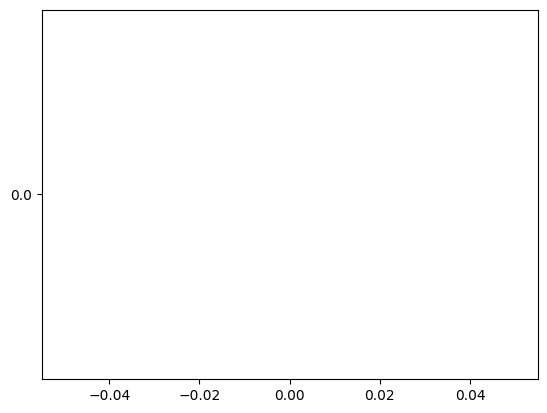

In [6]:
##########################################################################
##
##  PART 3
##
##########################################################################
#-------------------------------------------------------------------------
def execute_part3(encoder_rnn, decoder_attn_rnn, input_lang_obj, output_lang_obj, 
                  device, EOS_token, pairs, plot_losses):
    encoder_rnn.eval()
    decoder_attn_rnn.eval()

    evaluateRandomly(
        encoder_rnn         = encoder_rnn, 
        decoder_attn_rnn    = decoder_attn_rnn, 
        pairs               = pairs,
        input_lang_obj      = input_lang_obj, 
        output_lang_obj     = output_lang_obj, 
        device              = device,
        EOS_token           = EOS_token,
        n_executions        = 10
    ) 

    showPlot(points = plot_losses)
#-------------------------------------------------------------------------
execute_part3(
    encoder_rnn      = result_part2['encoder_rnn'], 
    decoder_attn_rnn = result_part2['decoder_attn_rnn'], 
    input_lang_obj   = result_part2['input_lang_obj'], 
    output_lang_obj  = result_part2['output_lang_obj'], 
    device           = result_part2['device'], 
    EOS_token        = result_part2['EOS_token'], 
    pairs            = result_part2['pairs'], 
    plot_losses      = result_part2['plot_losses']
)


### Part 4


input = il n est pas aussi grand que son pere
output = he is not a good at the same <EOS>


/var/folders/8s/xz8ky6j5743dp6h01ldgzgqc0000gn/T/ipykernel_83533/638225643.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(label1_list, rotation=90)
/var/folders/8s/xz8ky6j5743dp6h01ldgzgqc0000gn/T/ipykernel_83533/638225643.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_yticklabels(label2_list)


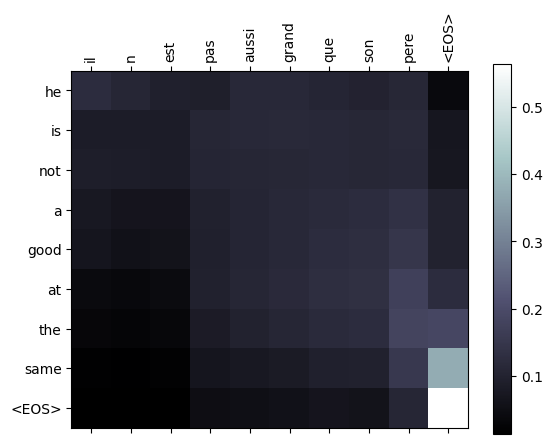

input = je suis trop fatigue pour conduire
output = i m not going to see you <EOS>


/var/folders/8s/xz8ky6j5743dp6h01ldgzgqc0000gn/T/ipykernel_83533/638225643.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(label1_list, rotation=90)
/var/folders/8s/xz8ky6j5743dp6h01ldgzgqc0000gn/T/ipykernel_83533/638225643.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_yticklabels(label2_list)


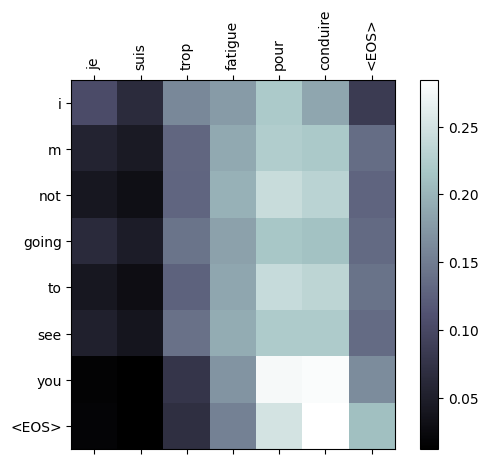

input = je suis desole si c est une question idiote
output = i m sorry i m not a little of you


/var/folders/8s/xz8ky6j5743dp6h01ldgzgqc0000gn/T/ipykernel_83533/638225643.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(label1_list, rotation=90)
/var/folders/8s/xz8ky6j5743dp6h01ldgzgqc0000gn/T/ipykernel_83533/638225643.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_yticklabels(label2_list)


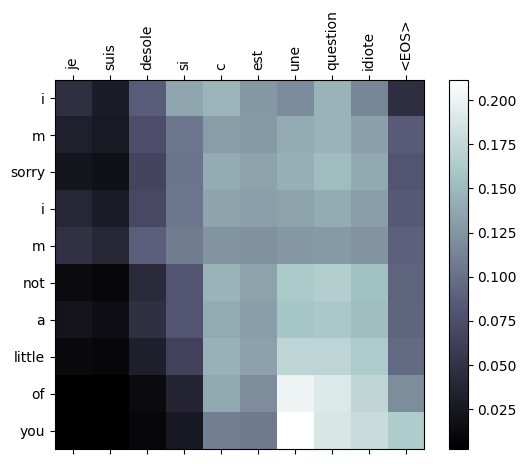

input = je suis reellement fiere de vous
output = i m sorry i m you <EOS>


/var/folders/8s/xz8ky6j5743dp6h01ldgzgqc0000gn/T/ipykernel_83533/638225643.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(label1_list, rotation=90)
/var/folders/8s/xz8ky6j5743dp6h01ldgzgqc0000gn/T/ipykernel_83533/638225643.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_yticklabels(label2_list)


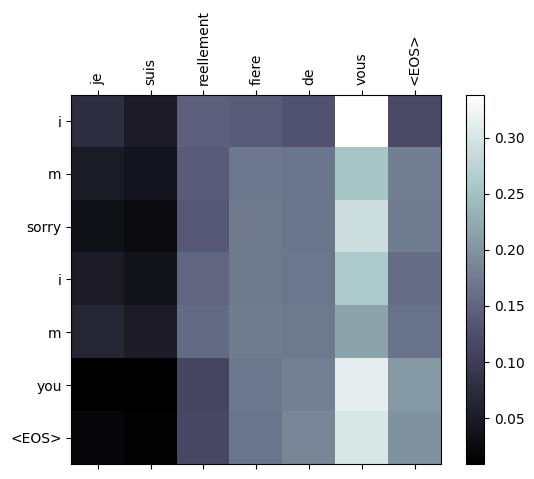

In [7]:
##########################################################################
##
##  PART 4
##
##########################################################################

#-------------------------------------------------------------------------
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()

    axes = fig.add_subplot(111) # 111 is shorhand for nrows=1, ncols=1, index=1

    # Converts the attentions tensor to a numpy array - the cpu() method ensures the tensor 
    #   is on the cpu, and numpy() converts it to a numpy array.
    # .matshow(...) useful defaults for displaying a matrix
    # cmap='bone': (colormap) is a grayscale colours scheme
    colour_axes = axes.matshow(attentions.cpu().numpy(), cmap='bone')

    fig.colorbar(colour_axes)

    # Set up axes
    label1_list = ['']
    label1_list.extend(input_sentence.split(' '))
    label1_list.append('<EOS>')
    axes.set_xticklabels(label1_list, rotation=90)

    label2_list = ['']
    label2_list.extend(output_words)
    axes.set_yticklabels(label2_list)

    # Show label at every tick
    axes.xaxis.set_major_locator(ticker.MultipleLocator(1))
    axes.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def evaluateAndShowAttention(input_sentence, encoder_rnn, decoder_attn_rnn, 
                             input_lang_obj, output_lang_obj, device, EOS_token, show_attention):

    output_words, attentions = evaluate(
        encoder_rnn         = encoder_rnn, 
        decoder_attn_rnn    = decoder_attn_rnn, 
        sentence            = input_sentence, 
        input_lang_obj      = input_lang_obj, 
        output_lang_obj     = output_lang_obj,
        device              = device,
        EOS_token           = EOS_token
    )

    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    if show_attention:
        showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
def execute_part4(encoder_rnn, decoder_attn_rnn, input_lang_obj, output_lang_obj,
                  device, EOS_token, show_attention):
    sentences_to_test = [
        'il n est pas aussi grand que son pere',
        'je suis trop fatigue pour conduire',
        'je suis desole si c est une question idiote',
        'je suis reellement fiere de vous'
    ]

    #---------------------------
    for sentence in sentences_to_test:
        evaluateAndShowAttention(
            input_sentence      = sentence, 
            encoder_rnn         = encoder_rnn, 
            decoder_attn_rnn    = decoder_attn_rnn, 
            input_lang_obj      = input_lang_obj, 
            output_lang_obj     = output_lang_obj,
            device              = device,
            EOS_token           = EOS_token,
            show_attention      = show_attention
        )
    #---------------------------
#-------------------------------------------------------------------------
execute_part4(
    encoder_rnn         = result_part2['encoder_rnn'], 
    decoder_attn_rnn    = result_part2['decoder_attn_rnn'], 
    input_lang_obj      = result_part2['input_lang_obj'], 
    output_lang_obj     = result_part2['output_lang_obj'],
    device              = result_part2['device'],
    EOS_token           = result_part2['EOS_token'],
    show_attention      = True
)


### Tests

In [13]:
execute_part4(
    encoder_rnn         = result_part2['encoder_rnn'], 
    decoder_attn_rnn    = result_part2['decoder_attn_rnn'], 
    input_lang_obj      = result_part2['input_lang_obj'], 
    output_lang_obj     = result_part2['output_lang_obj'],
    device              = result_part2['device'],
    EOS_token           = result_part2['EOS_token'],
    show_attention      = False
)

input = il n est pas aussi grand que son pere
output = he is not a good at the same <EOS>
input = je suis trop fatigue pour conduire
output = i m not going to see you <EOS>
input = je suis desole si c est une question idiote
output = i m sorry i m not a little of you
input = je suis reellement fiere de vous
output = i m sorry i m you <EOS>
